### 🎯 SNIsA en ResNet18
Entrenamos un modelo ResNet18 con CIFAR-10 empleando SNIsA. Vamos a estudiar como afecta el no aislamiento de los modelos trozeados a la exactitud del ensamblado, y a la eficiencia del desaprendizaje.

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import linear_model, model_selection
import pickle

# Suppress warnings and TensorFlow logs
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, metrics
from tensorflow.keras.utils import split_dataset
from tensorflow.python.client import device_lib

import keras_cv as kcv
from keras_cv import visualization
from keras_cv.models import ResNet18Backbone

Using TensorFlow backend


In [2]:
def set_device(mixed_precision=True, set_jit=False):
    # printed out the detected devices
    list_ld = device_lib.list_local_devices()
    for dev in list_ld:
        print(dev.name,dev.memory_limit)

    # get the lisf of physical devices
    physical_devices = tf.config.list_physical_devices(
        'GPU' if len(list_ld) - 1 else 'CPU'
    )
    # For GPU devices, configure related stuff
    if 'GPU' in physical_devices[-1]:
        tf.config.optimizer.set_jit(set_jit)
        if mixed_precision:
            keras.mixed_precision.set_global_policy(
                "mixed_float16"
            )
        else:
            keras.mixed_precision.set_global_policy(
                keras.backend.floatx()
            )
        for pd in physical_devices:
            tf.config.experimental.set_memory_growth(
                pd, True
            )
    strategy = tf.distribute.MirroredStrategy()
    return (strategy, physical_devices)

In [3]:
strategy, physical_devices = set_device(mixed_precision=True, set_jit=True)
physical_devices, strategy, tf.__version__

/device:CPU:0 268435456
/device:GPU:0 4254072832
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')],
 '2.15.1')

___
Descargamos y preparamos los datos de CIFAR-10.

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128

(x_train, y_train), held_out = keras.datasets.cifar10.load_data()
test_set, val_set = split_dataset(held_out, left_size=0.2)

In [5]:
def normalize(image, label, denorm=False):
    rescale = keras.layers.Rescaling(scale=1./255.)
    norms = keras.layers.Normalization(
        mean=[0.4914, 0.4822, 0.4465],
        variance=[np.square(0.2023), np.square(0.1994), np.square(0.2010)],
        invert=denorm,
        axis=-1,
    )

    if not denorm:
        image = rescale(image)
    return norms(image), label

In [6]:
# Esta función divide el conjunto de datos (no convertidos en un Dataset) en 'S' trozos de igual tamaño,
# proporcionando también los conjuntos a olvidar y retener

def sliced_ds_raw(x,y,S):
    x_slices = []
    y_slices = []
    ft_set_x=[]
    ft_set_y=[]
    rt_set_x=[]
    rt_set_y=[]

    # Calculate the size of each slice
    slice_size = x.shape[0] // S
    forget_size = slice_size // 10

    for i in range(S):
        start_index = i * slice_size
        end_index = start_index + slice_size
        x_slices.append(x[start_index:end_index])
        y_slices.append(y[start_index:end_index])
        ft_set_x.append(x[start_index:start_index+forget_size])
        ft_set_y.append(y[start_index:start_index+forget_size])
        rt_set_x.append(x[start_index+forget_size:end_index])
        rt_set_y.append(y[start_index+forget_size:end_index])

    return x_slices, y_slices, ft_set_x, ft_set_y, rt_set_x, rt_set_y

In [7]:
# Example usage:
(x_train, y_train), held_out = keras.datasets.cifar10.load_data()
S = 4
x_slices, y_slices, ft_set_x, ft_set_y, rt_set_x, rt_set_y = sliced_ds_raw(x_train, y_train, S)

# To check the shapes of the slices
for i in range(S):
    print(f"Slice {i+1} shape: x_slices: {x_slices[i].shape}, y_slices: {y_slices[i].shape}")
    print(f"Slice {i+1} shape: x_slices: {ft_set_x[i].shape}, y_slices: {ft_set_y[i].shape}")
    print(f"Slice {i+1} shape: x_slices: {rt_set_x[i].shape}, y_slices: {rt_set_y[i].shape}")


Slice 1 shape: x_slices: (12500, 32, 32, 3), y_slices: (12500, 1)
Slice 1 shape: x_slices: (1250, 32, 32, 3), y_slices: (1250, 1)
Slice 1 shape: x_slices: (11250, 32, 32, 3), y_slices: (11250, 1)
Slice 2 shape: x_slices: (12500, 32, 32, 3), y_slices: (12500, 1)
Slice 2 shape: x_slices: (1250, 32, 32, 3), y_slices: (1250, 1)
Slice 2 shape: x_slices: (11250, 32, 32, 3), y_slices: (11250, 1)
Slice 3 shape: x_slices: (12500, 32, 32, 3), y_slices: (12500, 1)
Slice 3 shape: x_slices: (1250, 32, 32, 3), y_slices: (1250, 1)
Slice 3 shape: x_slices: (11250, 32, 32, 3), y_slices: (11250, 1)
Slice 4 shape: x_slices: (12500, 32, 32, 3), y_slices: (12500, 1)
Slice 4 shape: x_slices: (1250, 32, 32, 3), y_slices: (1250, 1)
Slice 4 shape: x_slices: (11250, 32, 32, 3), y_slices: (11250, 1)


In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_ds = train_ds.map(normalize)
train_ds = train_ds.shuffle(buffer_size=8*BATCH_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = val_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [9]:
Slices=8 # slices

x_slices, y_slices, ft_set_x, ft_set_y, rt_set_x, rt_set_y = sliced_ds_raw(x_train, y_train, Slices)
sliced_datasets=[]
ft_datasets=[]
rt_datasets=[]

for i in range(Slices):
    ds=tf.data.Dataset.from_tensor_slices((x_slices[i], y_slices[i]))
    sliced_datasets.append(ds)

    ds=tf.data.Dataset.from_tensor_slices((ft_set_x[i], ft_set_y[i]))
    ft_datasets.append(ds)

    ds=tf.data.Dataset.from_tensor_slices((rt_set_x[i], rt_set_y[i]))
    rt_datasets.append(ds)

for i in range(Slices):
    sliced_datasets[i] = sliced_datasets[i].map(normalize)
    sliced_datasets[i] = sliced_datasets[i].shuffle(buffer_size=8*BATCH_SIZE)
    sliced_datasets[i] = sliced_datasets[i].batch(BATCH_SIZE).prefetch(AUTOTUNE)

    ft_datasets[i] = ft_datasets[i].map(normalize)
    ft_datasets[i] = ft_datasets[i].shuffle(buffer_size=8*BATCH_SIZE)
    ft_datasets[i] = ft_datasets[i].batch(BATCH_SIZE).prefetch(AUTOTUNE)

    rt_datasets[i] = rt_datasets[i].map(normalize)
    rt_datasets[i] = rt_datasets[i].shuffle(buffer_size=8*BATCH_SIZE)
    rt_datasets[i] = rt_datasets[i].batch(BATCH_SIZE).prefetch(AUTOTUNE)

___
Preparamos y entrenamos los distintos modelos ResNet18, y creamos el modelo de ensamblado

In [10]:
def get_model():
    with strategy.scope():
        model = keras.Sequential(
            [
                ResNet18Backbone(include_rescaling=False, input_shape=(32, 32, 3)),
                keras.layers.GlobalMaxPooling2D(),
                keras.layers.Dense(10, activation="softmax", dtype=tf.float32),
            ]
        )
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )

    return model

In [ ]:
# Entrenamos un primer modelo por N epochs, a partir del cual se entrenan los sliced_models

N=10

model=get_model()
history = model.fit(train_ds, validation_data=val_ds, epochs=N)

model.save('N_epoch_models/resnet18_cifar10_'+str(N)+'.keras', save_format="keras_v3")

In [ ]:
# Entrenamos los modelos con los datos troceados a partir del modelo anterior

N=0
model = keras.saving.load_model('N_epoch_models/resnet18_cifar10_'+str(N)+'.keras')
print('Model resnet18_cifar10_'+str(N)+' loaded')

models = []

for s in range(Slices):
    model_copy = tf.keras.models.clone_model(model)
    model_copy.set_weights(model.get_weights())
    model_copy.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )

    models.append(model_copy)
    
    model_copy.fit(sliced_datasets[s], validation_data=val_ds, epochs=20-N)

    save_path = 'N_epoch_models/'+str(N)+'_sliced_models/'+str(N)+'_slice_'+str(Slices)+'_'+str(s)+'.keras'
    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    model_copy.save(save_path, save_format="keras_v3")

    print(f"Finished iteration {s}")

In [ ]:
# Análisis de la exactitud de los modelos en el conjunto de datos de entrenamiento

for s in range(Slices):
    model = models[s]
    print(f"Train set accuracy: {100.0 * model.evaluate(sliced_datasets[s])[-1]:0.1f}%%")
    print(f"Test set accuracy: {100.0 * model.evaluate(test_ds)[-1]:0.1f}%%")

In [ ]:
# Ensamblado de los 'S' modelos en uno, cuyo output es la media de todos

for s in range(Slices):
    models[s]._name='sequential_'+str(s)
    print(models[s]._name)

model_input = tf.keras.Input(shape=(32, 32, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

ensemble_model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )

In [ ]:
# Análisis de la exactitud en el conjunto de datos de entrenamiento

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(normalize)
train_ds = train_ds.shuffle(buffer_size=8*BATCH_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print(f"Train set accuracy: {100.0 * ensemble_model.evaluate(train_ds)[-1]:0.1f}%")
print(f"Test set accuracy: {100.0 * ensemble_model.evaluate(test_ds)[-1]:0.1f}%")

___
Comprobamos la efectividad de un MIA en el modelo de ensamblado.

In [11]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        reduction="none"
    )
    all_losses = []

    for inputs, targets in tqdm(loader):
        logits = net(inputs, training=False)
        losses = loss_fn(targets, logits).numpy()
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

In [12]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

In [13]:
# ! Preprocesar 'train_ds' antes de obtener los conjutos a olvidar y retener

forget_set, retain_set = keras.utils.split_dataset(train_ds.unbatch(), left_size=0.1)
forget_ds = forget_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
retain_ds = retain_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
print('A olvidar:', int(forget_set.cardinality()),', a retener:', int(retain_set.cardinality()))

A olvidar: 5000 , a retener: 45000


In [ ]:
forget_losses = compute_losses(ensemble_model, forget_ds)
test_losses = compute_losses(ensemble_model, test_ds)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[:len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA attack has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

In [ ]:
import pickle

# Getting back the objects:
with open('SNIsA.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    [NIepochs, pre_accuracy_train, pre_accuracy_test, pre_mia_score, accuracy_train, accuracy_test, mia_score] = pickle.load(f)

pre_accuracy_train[0]=ensemble_model.evaluate(train_ds)[-1]
pre_accuracy_test[0]=ensemble_model.evaluate(test_ds)[-1]
pre_mia_score[0]=mia_scores.mean()

# Saving the objects:
with open('SNIsA.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([NIepochs, pre_accuracy_train, pre_accuracy_test, pre_mia_score, accuracy_train, accuracy_test, mia_score], f)

___
Gráfica de exactitud y efectividad del MIA frente a S, del modelo de ensablado re-entrenado.

In [14]:
# Entrenamos los modelos con los datos troceados a partir del modelo anterior

N=0
# model = keras.saving.load_model('N_epoch_models/resnet18_cifar10_'+str(N)+'.keras')
# print('Model resnet18_cifar10_'+str(N)+' loaded')

models = []

for s in range(Slices):
    model_copy = tf.keras.models.clone_model(model)
    model_copy.set_weights(model.get_weights())
    model_copy.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )

    models.append(model_copy)
    
    model_copy.fit(rt_datasets[s], validation_data=val_ds, epochs=20-N)

    save_path = 'N_epoch_models/'+str(N)+'_sliced_models/'+str(N)+'_retain_'+str(Slices)+'_'+str(s)+'.keras'
    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    model_copy.save(save_path, save_format="keras_v3")

    print(f"Finished iteration {s}")

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

I0000 00:00:1716838044.881351   40402 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 [==============================] - ETA: 0s - loss: 2.2288 - accuracy: 0.3036INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
44/44 [==============================] - 61s 735ms/step - loss: 2.2288 - accuracy: 0.3036 - val_loss: 2.4542 - val_accuracy: 0.1976
Epoch 2/20
44/44 [==============================] - 1s 30ms/step - loss: 1.4771 - accuracy: 0.4571 - val_loss: 1.9388 - val_accuracy: 0.2627
Epoch

In [15]:
# Ensamblado de los 'S' modelos en uno, cuyo output es la media de los todos

for s in range(Slices):
    models[s]._name='sequential_'+str(s)
    print(models[s]._name)
    
model_input = tf.keras.Input(shape=(32, 32, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

ensemble_model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )

sequential_0
sequential_1
sequential_2
sequential_3
sequential_4
sequential_5
sequential_6
sequential_7


In [16]:
forget_ds = ft_datasets[0]
for dataset in ft_datasets[1:]:
    forget_ds = forget_ds.concatenate(dataset)

forget_losses = compute_losses(ensemble_model, forget_ds)
test_losses = compute_losses(ensemble_model, test_ds)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[:len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA attack has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

# Getting back the objects:
with open('SNIsA.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    [NIepochs, pre_accuracy_train, pre_accuracy_test, pre_mia_score, accuracy_train, accuracy_test, mia_score] = pickle.load(f)

accuracy_train[0]=ensemble_model.evaluate(train_ds)[-1]
accuracy_test[0]=ensemble_model.evaluate(test_ds)[-1]
mia_score[0]=mia_scores.mean()

# Saving the objects:
with open('SNIsA.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([NIepochs, pre_accuracy_train, pre_accuracy_test, pre_mia_score, accuracy_train, accuracy_test, mia_score], f)

100%|██████████| 16/16 [00:16<00:00,  1.04s/it]

The MIA attack has an accuracy of 0.488 on forgotten vs unseen images
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce te

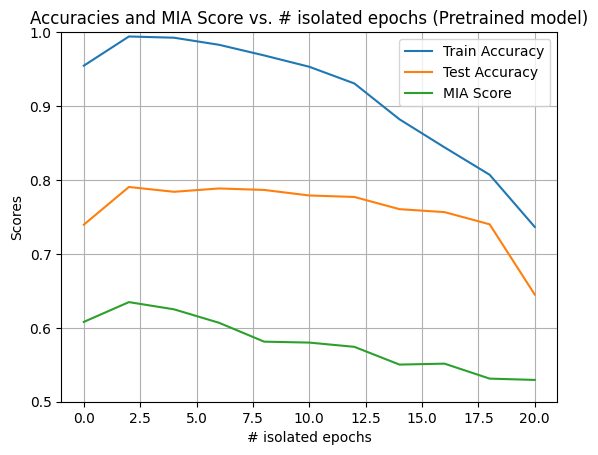

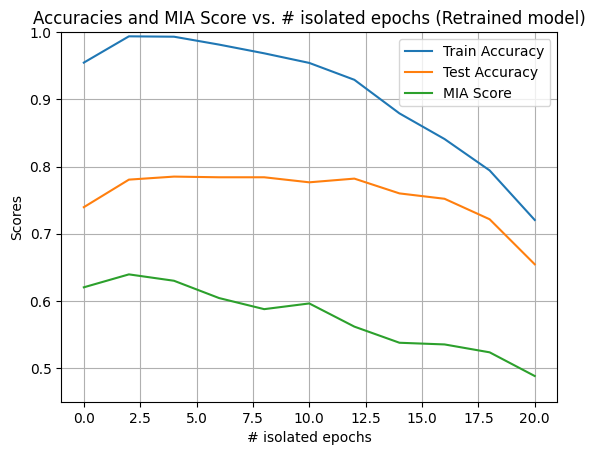

In [18]:
plt.plot(NIepochs, pre_accuracy_train, label='Train Accuracy')
plt.plot(NIepochs, pre_accuracy_test, label='Test Accuracy')
plt.plot(NIepochs, pre_mia_score, label='MIA Score')

plt.xlabel('# isolated epochs')
plt.ylabel('Scores')
plt.title('Accuracies and MIA Score vs. # isolated epochs (Pretrained model)')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(0.5,1)
plt.show()

plt.plot(NIepochs, accuracy_train, label='Train Accuracy')
plt.plot(NIepochs, accuracy_test, label='Test Accuracy')
plt.plot(NIepochs, mia_score, label='MIA Score')

plt.xlabel('# isolated epochs')
plt.ylabel('Scores')
plt.title('Accuracies and MIA Score vs. # isolated epochs (Retrained model)')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(0.45,1)
plt.show()

______
### Utilidades

In [ ]:
# Cargar los modelos guardados

N=2
Slices=8

models=[]
for s in range(Slices):
    save_path = 'N_epoch_models/'+str(N)+'_sliced_models/'+str(N)+'_slice_'+str(Slices)+'_'+str(s)+'.keras'
    model = keras.saving.load_model(save_path)
    models.append(model)
    print('N: ', N,' sliced model ', s, ' loaded')

In [ ]:
# Renombrar modelos si se repiten los nombres

for s in range(Slices):
    models[s]._name='sequential_'+str(s)
    print(models[s]._name)

In [ ]:
import pickle

# Saving the objects:
with open('objs.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([NIepochs, pre_accuracy_train, pre_accuracy_test, pre_mia_score, accuracy_train, accuracy_test, mia_score], f)

In [ ]:
import pickle

# Getting back the objects:
with open('objs.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    [NIepochs, pre_accuracy_train, pre_accuracy_test, pre_mia_score, accuracy_train, accuracy_test, mia_score] = pickle.load(f)